In [1]:
!pip install kaggle

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [3]:
!kaggle datasets download -d lizwozsliz/data-raiden-shogun

100% 1.92G/1.93G [00:27<00:00, 93.9MB/s]
100% 1.93G/1.93G [00:27<00:00, 76.3MB/s]


In [4]:
!unzip -q data-raiden-shogun.zip -d dataset

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming that '/content/dataset/Data raiden shogun' is the path to the unzipped dataset
train_dir = '/content/dataset/Data raiden shogun/train'
validation_dir = '/content/dataset/Data raiden shogun/validation'

# Initialize the data generators
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Prepare the data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Change this if you need a different size
    batch_size=32,
    class_mode='binary')  # Use 'categorical' for multi-class classification

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),  # Change this if you need a different size
    batch_size=32,
    class_mode='binary')  # Use 'categorical' for multi-class classification

Found 606 images belonging to 2 classes.
Found 607 images belonging to 2 classes.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  # Use 'softmax' for multi-class classification
])

In [10]:
model.compile(loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
              optimizer='adam',
              metrics=['accuracy'])

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/10
18/18 [==============================] - 187s 11s/step - loss: 0.8512 - accuracy: 0.8432 - val_loss: 0.3749 - val_accuracy: 0.8785
Epoch 2/10
18/18 [==============================] - 189s 11s/step - loss: 0.2638 - accuracy: 0.8902 - val_loss: 0.1667 - val_accuracy: 0.9444
Epoch 3/10
18/18 [==============================] - 152s 9s/step - loss: 0.1865 - accuracy: 0.9286 - val_loss: 0.1525 - val_accuracy: 0.9149
Epoch 4/10
18/18 [==============================] - 151s 9s/step - loss: 0.0882 - accuracy: 0.9704 - val_loss: 0.2975 - val_accuracy: 0.8663
Epoch 5/10
18/18 [==============================] - 156s 9s/step - loss: 0.2046 - accuracy: 0.9028 - val_loss: 0.1485 - val_accuracy: 0.9045
Epoch 6/10
18/18 [==============================] - 182s 10s/step - loss: 0.0991 - accuracy: 0.9634 - val_loss: 0.0599 - val_accuracy: 0.9705
Epoch 7/10
18/18 [==============================] - 182s 10s/step - loss: 0.0591 - accuracy: 0.9774 - val_loss: 0.0367 - val_accuracy: 0.9931
Epoch 8/1

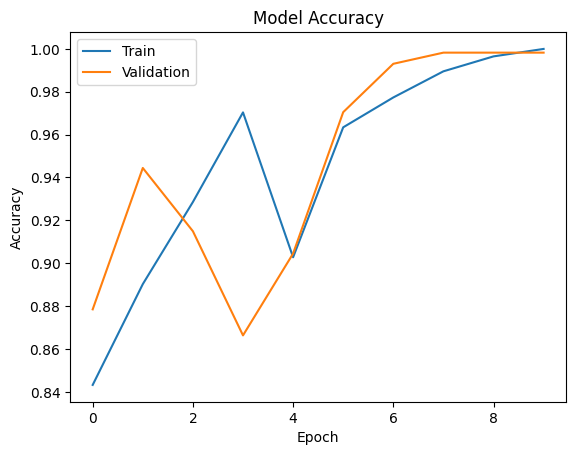

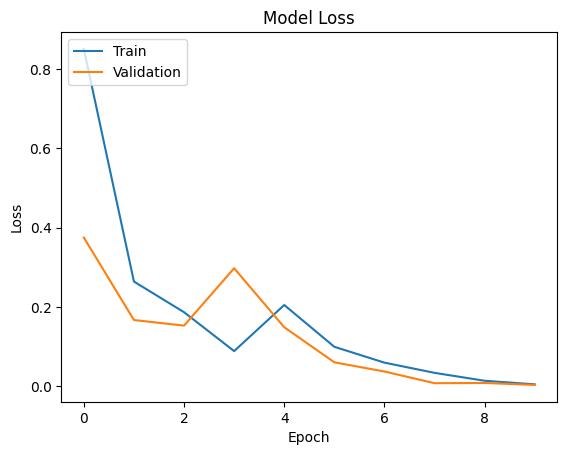

In [12]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [13]:
model.save('/content/raiden_shogun_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
from PIL import Image, ImageDraw, ImageFont

# Load the trained model
model_path = '/content/raiden_shogun_model.h5'
model = load_model(model_path)

def predict_and_annotate(image_paths, model, target_size=(224, 224)):
    annotated_images = []

    for image_path in image_paths:
        # Load and preprocess the image
        image = load_img(image_path, target_size=target_size)
        image_array = img_to_array(image)
        image_array = np.expand_dims(image_array, axis=0)
        image_array /= 255.0

        # Predict the class of the image
        prediction = model.predict(image_array)

        # Determine the class label and probability
        class_label = 'AI-generated' if prediction >= 0.5 else 'Human-created'
        probability = prediction[0][0] if prediction >= 0.5 else 1 - prediction[0][0]

        # Load the image to overlay the text
        image = Image.open(image_path)
        draw = ImageDraw.Draw(image)
        font = ImageFont.load_default()

        # Prepare the text
        text = f"{class_label}: {probability:.2%}"

        # Position the text at the bottom center of the image
        text_width, text_height = draw.textsize(text, font=font)
        text_position = ((image.width - text_width) // 2, image.height - text_height - 10)

        # Draw the text on the image
        draw.text(text_position, text, (255, 255, 255), font=font)

        annotated_images.append(image)

    return annotated_images

# List of image paths to process
image_paths = ['/content/dataset/Data raiden shogun/test/ai_generated/sailor_ojisan113649237_p0.png', '/content/dataset/Data raiden shogun/test/ai_generated/望霙113636120_p0.png',]

# Predict and annotate images
annotated_images = predict_and_annotate(image_paths, model)

# Save or display the annotated images
for i, img in enumerate(annotated_images):
    img.save(f'annotated_image_{i}.png')
    img.show()


1/1 [==============================] - 0s 126ms/step


<ipython-input-25-9363144fabe4>:37: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


1/1 [==============================] - 0s 68ms/step


<ipython-input-25-9363144fabe4>:37: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


1/1 [==============================] - 0s 103ms/step


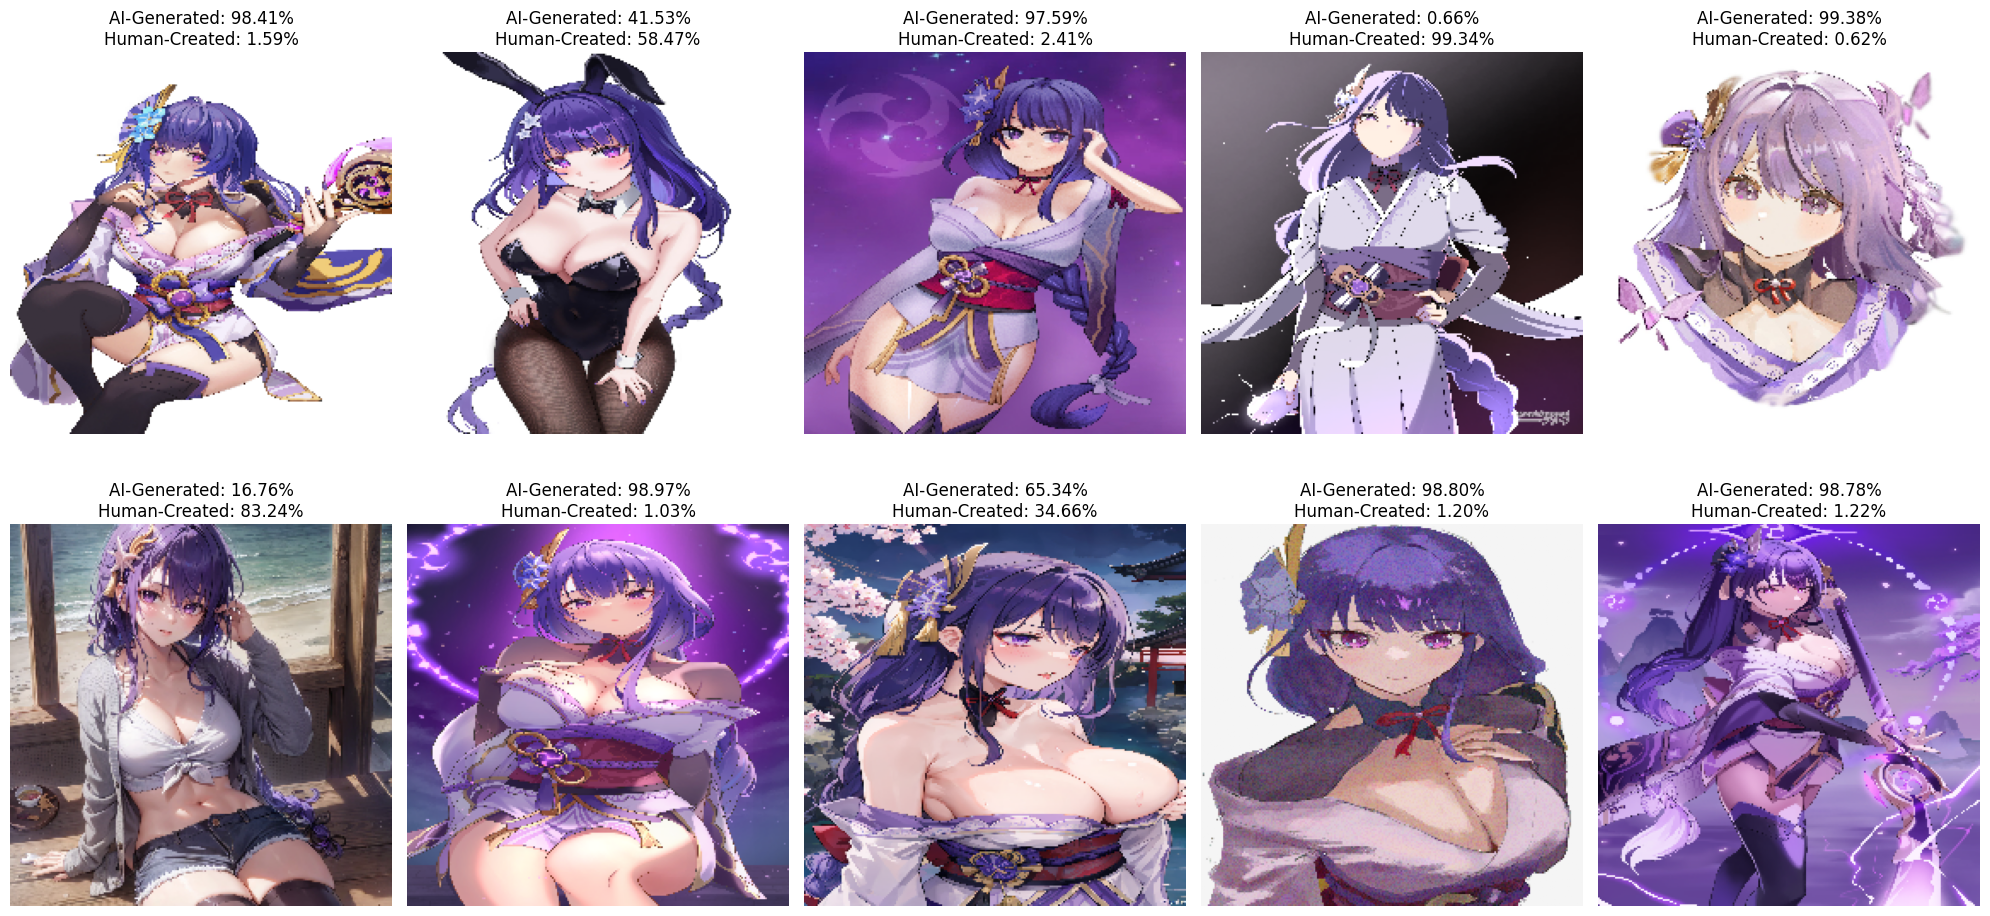

In [29]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import os

# Load your trained model
model = load_model('/content/raiden_shogun_model.h5')

# Directory with your test images
test_dir = '/content/test'
test_images = os.listdir(test_dir)

# Preprocess all test images
test_imgs = []
for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    img = image.load_img(img_path, target_size=(224, 224))  # Replace with the input size of your model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    test_imgs.append(img_array)

# Run predictions
predictions = [model.predict(img) for img in test_imgs]

# Visualize results
plt.figure(figsize=(20, 10))
for i, (img_array, prediction) in enumerate(zip(test_imgs, predictions)):
    plt.subplot(2, 5, i + 1)  # Adjust depending on the number of images
    plt.imshow(np.squeeze(img_array))
    plt.title(f'AI-Generated: {prediction[0][0]:.2%}\nHuman-Created: {1 - prediction[0][0]:.2%}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load your trained model
model = load_model('/content/raiden_shogun_model.h5')

# Assuming '/content/dataset/Data raiden shogun/test' is the path to your test data
test_dir = '/content/dataset/Data raiden shogun/test'

# Initialize the test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare the test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # The target size should match the input size of your model
    batch_size=32,
    class_mode='binary',  # Use 'categorical' if you have more than two classes
    shuffle=False
)

# Make sure to reset the test_generator before calling predict,
# to ensure it's in the same order as when calling evaluate
test_generator.reset()

# Predict on the test data
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size+1)
# Convert predictions to binary (you might need to adjust this based on your problem)
y_pred = np.where(Y_pred > 0.5, 1, 0)

# Get the true labels
y_true = test_generator.classes

# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred)
classif_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())

print("Confusion Matrix")
print(conf_matrix)
print("\n")
print("Classification Report")
print(classif_report)


Found 64 images belonging to 2 classes.
2/3 [===================>..........] - ETA: 4s

3/3 [==============================] - 7s 2s/step
Confusion Matrix
[[47  5]
 [ 1 11]]


Classification Report
               precision    recall  f1-score   support

 ai_generated       0.98      0.90      0.94        52
human_created       0.69      0.92      0.79        12

     accuracy                           0.91        64
    macro avg       0.83      0.91      0.86        64
 weighted avg       0.92      0.91      0.91        64

